In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

### Dataset didapatkan dari kaggle datasets download -d cornflake15/denpasarbalihistoricalweatherdata



In [ ]:
dataframe = pd.read_csv('openweatherdata-denpasar-1990-2020v0.1.csv',parse_dates=['dt_iso'])

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dt_iso               264924 non-null  datetime64[ns]
 1   timezone             264924 non-null  int64         
 2   city_name            264924 non-null  object        
 3   lat                  264924 non-null  float64       
 4   lon                  264924 non-null  float64       
 5   temp                 264924 non-null  float64       
 6   temp_min             264924 non-null  float64       
 7   temp_max             264924 non-null  float64       
 8   pressure             264924 non-null  float64       
 9   humidity             264924 non-null  int64         
 10  wind_speed           264924 non-null  float64       
 11  wind_deg             264924 non-null  int64         
 12  rain_1h              16286 non-null   float64       
 13  rain_3h       

In [ ]:
#MEMBUAT RATA-RATA SUHU PERHARI

dataframe.dt_iso = pd.to_datetime(dataframe['dt_iso']).dt.normalize()

dataframe = dataframe.groupby('dt_iso',as_index=False).temp.mean()

dataframe.head()

,dt_iso,temp
0,1990-01-01,26.333750
1,1990-01-02,25.559583
2,1990-01-03,26.956667
3,1990-01-04,26.638750
4,1990-01-05,27.940417


In [ ]:
n = len(dataframe)
dataframe = dataframe[n-10000:]

df_baru = dataframe[['dt_iso','temp']]
df_baru.tail()

,dt_iso,temp
10959,2020-01-03,28.666667
10960,2020-01-04,28.083333
10961,2020-01-05,28.958333
10962,2020-01-06,28.708333
10963,2020-01-07,28.458333


In [ ]:
df_baru.isnull().sum()

dt_iso    0
temp      0
dtype: int64

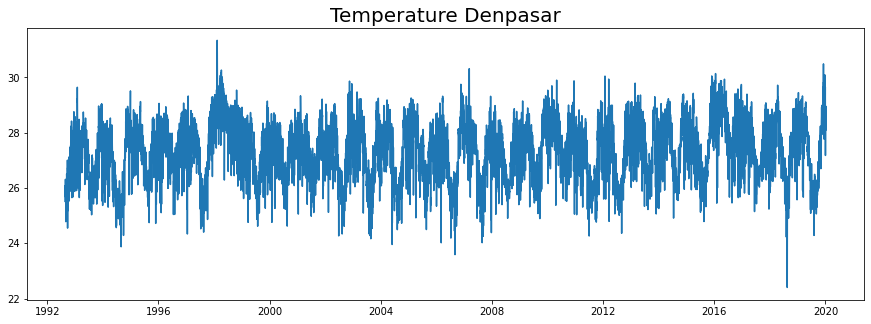

In [ ]:
datetime = df_baru['dt_iso'].values
temperature  = df_baru['temp'].values

plt.figure(figsize=(15,5))
plt.plot(datetime, temperature)
plt.title('Temperature Denpasar',
          fontsize=20);

Di atas merupakan Grafik data temperature kota denpasar 10000 hari 1/7/2020 ke belakang

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(df_baru,test_size=0.2,shuffle=False)

print("Jumlah data training: ",len(data_train))
print("Jumlah data test: ",len(data_test))

data_test

Jumlah data training:  8000
Jumlah data test:  2000


,dt_iso,temp
8964,2014-07-18,25.818750
8965,2014-07-19,26.171667
8966,2014-07-20,26.230833
8967,2014-07-21,26.582917
8968,2014-07-22,26.701250
...,...,...
10959,2020-01-03,28.666667
10960,2020-01-04,28.083333
10961,2020-01-05,28.958333
10962,2020-01-06,28.708333


In [ ]:
#NORMALIZE DATA

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler = scaler.fit(data_train['temp'].values.reshape(-1,1))

data_train = scaler.transform(data_train['temp'].values.reshape(-1,1))
data_test = scaler.transform(data_test['temp'].values.reshape(-1,1))

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(data_train.flatten(), window_size=100, batch_size=100, shuffle_buffer=100)
test_set = windowed_dataset(data_test.flatten(), window_size=100, batch_size=100, shuffle_buffer=100)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
])

In [ ]:
#FUNGSI CALLBACK
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nMAE telah mencapai <10% skala data!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=300,validation_data=test_set,callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/300
79/79 [==============================] - 23s 229ms/step - loss: 0.0911 - mae: 0.4002 - val_loss: 0.0785 - val_mae: 0.3728
Epoch 2/300
79/79 [==============================] - 17s 215ms/step - loss: 0.0507 - mae: 0.2855 - val_loss: 0.0487 - val_mae: 0.2838
Epoch 3/300
79/79 [==============================] - 17s 216ms/step - loss: 0.0350 - mae: 0.2255 - val_loss: 0.0326 - val_mae: 0.2240
Epoch 4/300
79/79 [==============================] - 17s 215ms/step - loss: 0.0261 - mae: 0.1892 - val_loss: 0.0236 - val_mae: 0.1855
Epoch 5/300
79/79 [==============================] - 17s 215ms/step - loss: 0.0219 - mae: 0.1714 - val_loss: 0.0185 - val_mae: 0.1618
Epoch 6/300
79/79 [==============================] - 17s 218ms/step - loss: 0.0191 - mae: 0.1580 - val_loss: 0.0155 - val_mae: 0.1466
Epoch 7/300
79/79 [==============================] - 17s 218ms/step - loss: 0.0182 - mae: 0.1549 - val_loss: 0.0136 - val_mae: 0.1365
Epoch 8/300
79/79 [==============================] - 17s 215ms

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

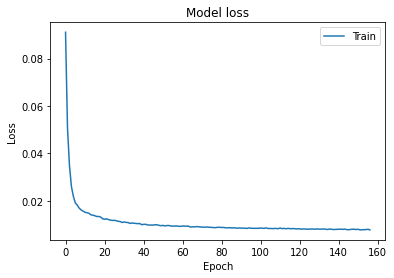

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()